# Project Overview

Project goal is to generate a cleaned and merged data file in csv format, given 3 ficticious datasets, and provide notes as to what was found in the data, including any missing data.

## Provided Files:
1. Assessment file (sample_assessment.csv): Manhattan School District standardized test results - please include Math score.
2. Math product Usage file (sample_usage.csv): Please include both lessons completed and total minutes columns in the merged file. Students in grade levels 5, 6, 7, and 8 have access to the Math product.
3. SIS file (sample_sis.csv): Please include all information listed in this file (all students in grade levels 5, 6, 7, and 8) and all columns.



# Setup

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Allows plots to be rendered inside the notebook
%matplotlib inline

In [2]:
# Load files
sis_data = pd.read_csv('./resources/sample_sis.csv')
assessment_data = pd.read_csv('./resources/sample_assessment.csv')
usage_data = pd.read_csv('./resources/sample_usage.csv')

In [3]:
# Create list of dataframes for ease of programming
dataframes = [("SIS Data", sis_data), ("Assessment Data", assessment_data), ("Usage Data", usage_data)]

# Data Overview

In [4]:
# View headers
sis_data.head()

,student_id,grade_level,race_ethnicity,gender,Free/Reduced Price Lunch
0,1254353,7,White,Male,No
1,1254135,5,White,Male,NaN
2,1254423,8,Black/African American,Male,Reduced Price
3,1254598,8,White,Male,Free
4,1254562,6,Black/African American,Male,No


In [5]:
assessment_data.head()

,id,student_number,subject,score
0,1254397,54912357,ELA,190
1,1254204,54912164,ELA,567
2,1254785,54912745,ELA,390
3,1254308,54912268,Math,719
4,1254560,54912520,ELA,394


In [6]:
usage_data.head()

,student_id,lesson completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
0,1254110,13,level 2,level 1,level 3,level 2,47.808670
1,1254113,14,level 2,level 1,level4,level 1,156.792335
2,1254288,16,level 3,level 1,level 3,level 1,38.135959
3,1254095,15,level 3,level 1,level 1,level 1,18.257427
4,1254250,1,level 2,level 1,level 2,level 2,16.479016


## Cursory Observations
- Relationship column between files is Student ID (student_id).
    - While the Usage & SIS files have a clearly labeled student_id column, the Assessment file has two possible columns that could be Student ID, either id or student_number. 
    - All id-related columns have 7 digits, but the id column in the Assessments file has similar leading numbers as the student_id columns in the other two files.
- Additional header observations:
    - File headers have incongruent formats- spacing vs underscores, mixed casing, includes slash character. 
    - The directions require “lessons completed”, whereas the column header is “lesson completed”.
- NaN value is present in Free/Reduced Price Lunch.
- Benchmark value format is inconsistent.
- Since Math scores are the focus, I'll need to check & filter the subject column.
- Since Grade Level determines access to the Usage file, I'll need to check and filter the grade_level column.

# Normalize Headers

In [7]:
custom_mappings = {
    'lesson_completed': 'lessons_completed',
    'id': 'student_id'
}

for name, df in dataframes:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace(r'[^\w]', '')
    if custom_mappings:
        df.rename(columns=custom_mappings, inplace=True)


# Analyze Data in Preparation for Merge

In [8]:
for name, df in dataframes:
    print(name, "Info:")
    df.info()
    print("\n")

SIS Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   student_id                783 non-null    int64 
 1   grade_level               783 non-null    int64 
 2   race_ethnicity            736 non-null    object
 3   gender                    783 non-null    object
 4   free_reduced_price_lunch  669 non-null    object
dtypes: int64(2), object(3)
memory usage: 30.7+ KB


Assessment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      1280 non-null   int64 
 1   student_number  1280 non-null   int64 
 2   subject         1280 non-null   object
 3   score           1280 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 40.1+ KB


Usage

<div class="alert alert-block alert-success">
<b>Data Type Consistency</b> Column Data Types are as expected. Student ID's and other int-expected columns are integers. Columns with expected string values are objects. Total minutes are floats.
</div>

<div class="alert alert-block alert-danger">
<b>Null or NaN:</b> I can see there are Null or NaN values in the SIS Data for columns race/ethnicity and free/reduced price lunch, but these are non-essential columns.
</div>

## Check ID Columns for Duplicates

In [9]:
for name, df in dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Data has duplicates?: True
Usage Data has duplicates?: False


<div class="alert alert-block alert-warning">
<b>Duplicates as Expected:</b> Assessment Data has student scores for both Math & ELA. SIS & Usage have no duplicates. Assessment Data will need to be handled accordingly.
</div>

## Check Numeric Columns for Inconsistencies

In [10]:
# Check specific columns for values less than 0
for name, df in dataframes:
    print(f"Checking {name}...")
    found = False
    for column in df.select_dtypes(include=['number']).columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if (df[column] < lower_bound).any() | (df[column] > upper_bound).any():
                found = True
                print(f"  Column '{column}' in {name} has outliers.")
            if (df[column] < 1).any():
                found = True
                print(f"  Column '{column}' in {name} has less than 1.")
            if (df[column] == 0).any():
                found = True
                print(f"  Column '{column}' in {name} has zeroes.")
            if (df[column] < 0).any():
                found = True
                print(f"  Column '{column}' in {name} has negatives.")

    if (not found):
        print("No inconsistencies found.")

Checking SIS Data...
No inconsistencies found.
Checking Assessment Data...
No inconsistencies found.
Checking Usage Data...
  Column 'total_minutes' in Usage Data has outliers.
  Column 'total_minutes' in Usage Data has less than 1.


In [11]:
# Usage IDs
usage_data.describe()['total_minutes']

count    349.000000
mean      76.705856
std       56.142303
min        0.167026
25%       32.308333
50%       65.030197
75%      111.739739
max      280.517175
Name: total_minutes, dtype: float64

In [12]:
def get_outliers_and_issues(df):
    result_rows = pd.DataFrame()
    
    for column in df.select_dtypes(include=['number']).columns:
        col_data = df[column]
        
        # Calculate IQR for outlier detection
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify rows with issues
        issues = df[(col_data < lower_bound) | 
                    (col_data > upper_bound) | 
                    (col_data == 0) | 
                    (col_data < 0) |
                    (col_data < 1)]
        
        # Add a column to indicate which issue was detected
        issues = issues.copy()  # Avoid SettingWithCopyWarning
        issues['issue_column'] = column  # Column with the detected issue
        
        result_rows = pd.concat([result_rows, issues])
    
    # Remove duplicates in case multiple columns flagged the same row
    return result_rows.drop_duplicates()

# Example Usage
outlier_rows = get_outliers_and_issues(usage_data)
print(outlier_rows)


     student_id  lessons_completed benchmark_1_level benchmark_2_level  \
16      1254138                 12            level4           level 3   
24      1254393                 16           level 2           level 2   
69      1254280                  4           level 1           level 2   
154     1254252                  9           level 3           level 3   
171     1254367                 13            level4           level 3   
179     1254255                 14           level 2           level 3   
261     1254284                 23           level 3           level 2   

    benchmark_3_level benchmark_4_level  total_minutes   issue_column  
16            level 1           level 3     255.231657  total_minutes  
24            level 1           level 1       0.167026  total_minutes  
69            level 1           level 1     261.391669  total_minutes  
154           level 2            level4     247.638391  total_minutes  
171           level 2           level 2     280

<div class="alert alert-block alert-danger">
<b>Total Minutes < 1</b> Data shows 3 students were able to complete between 14-23 lessons in less than 1 minute.
</div>

In [13]:
# Check SIS Grade Levels are as expected (5-8)
print(sis_data['grade_level'].unique())

[7 5 8 6]


In [14]:
# Check SIS Race/Ethnicity values
print(sis_data['race_ethnicity'].unique())

['White' 'Black/African American' 'Two or More Races' nan 'Asian'
 'Native Havaiian/Other Pacific Islander' 'American Indian/Alaska Native'
 'Hispanic/Latino']


In [15]:
# Check SIS Gender values
print(sis_data['gender'].unique())

['Male' 'Female']


In [16]:
# Check SIS Free/Reduced Price Lunch values
print(sis_data['free_reduced_price_lunch'].unique())

['No' nan 'Reduced Price' 'Free']


In [17]:
# Check Assessment Subjects are as expected (Math or ELA)
print(assessment_data['subject'].unique())

['ELA' 'Math']


## Handle SIS Data

In [18]:
# Check all SIS columns for NaN or blank values
null_counts = sis_data.isnull().sum()
blank_counts = sis_data.apply(lambda col: col.astype(str).str.strip().eq('').sum())

# Combine into a summary DataFrame
issue_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Blank Count': blank_counts
})
print(issue_summary)


                          Null Count  Blank Count
student_id                         0            0
grade_level                        0            0
race_ethnicity                    47            0
gender                             0            0
free_reduced_price_lunch         114            0


In [19]:
# Get the IDs where NaN in SIS Race/Ethnicity column
ids_with_race_nan = sis_data[sis_data['race_ethnicity'].isna()]['student_id'].tolist()
print(ids_with_race_nan)

# Filter rows with NaN in Race/Ethnicity column
race_ethnicity_nans = sis_data[sis_data['race_ethnicity'].isna()]
race_ethnicity_nans.head(5)

[1254825, 1254771, 1254180, 1254104, 1254079, 1254332, 1254503, 1254475, 1254810, 1254574, 1254378, 1254328, 1254327, 1254815, 1254364, 1254350, 1254745, 1254755, 1254756, 1254299, 1254545, 1254643, 1254488, 1254089, 1254778, 1254537, 1254291, 1254555, 1254616, 1254305, 1254214, 1254245, 1254387, 1254762, 1254663, 1254461, 1254689, 1254377, 1254449, 1254735, 1254518, 1254094, 1254249, 1254549, 1254493, 1254192, 1254708]


,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
33,1254825,7,NaN,Male,NaN
35,1254771,5,NaN,Male,No
48,1254180,8,NaN,Male,NaN
61,1254104,8,NaN,Male,No
65,1254079,5,NaN,Female,No


In [20]:
# Get the IDs where NaN in SIS Free/Reduced Lunch column
ids_with_lunch_nan = sis_data[sis_data['free_reduced_price_lunch'].isna()]['student_id'].tolist()
print(ids_with_lunch_nan)

# Filter rows with NaN in SIS Free/Reduced Lunch column
free_reduced_price_lunch_nans = sis_data[sis_data['free_reduced_price_lunch'].isna()]
free_reduced_price_lunch_nans.head(5)

[1254135, 1254128, 1254588, 1254529, 1254825, 1254767, 1254180, 1254112, 1254308, 1254819, 1254292, 1254516, 1254799, 1254577, 1254489, 1254508, 1254258, 1254212, 1254166, 1254839, 1254614, 1254743, 1254436, 1254260, 1254617, 1254666, 1254441, 1254400, 1254583, 1254818, 1254628, 1254697, 1254726, 1254760, 1254201, 1254700, 1254167, 1254533, 1254654, 1254746, 1254363, 1254442, 1254824, 1254123, 1254541, 1254576, 1254478, 1254840, 1254426, 1254627, 1254664, 1254597, 1254343, 1254846, 1254324, 1254147, 1254145, 1254256, 1254836, 1254089, 1254276, 1254837, 1254551, 1254572, 1254605, 1254222, 1254103, 1254404, 1254233, 1254136, 1254672, 1254205, 1254099, 1254295, 1254710, 1254163, 1254655, 1254293, 1254220, 1254121, 1254111, 1254307, 1254543, 1254582, 1254278, 1254625, 1254741, 1254229, 1254369, 1254482, 1254134, 1254550, 1254368, 1254348, 1254590, 1254440, 1254641, 1254548, 1254281, 1254325, 1254411, 1254479, 1254785, 1254669, 1254091, 1254843, 1254702, 1254119, 1254829, 1254523, 1254624, 

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
1,1254135,5,White,Male,NaN
17,1254128,8,White,Male,NaN
19,1254588,7,Two or More Races,Male,NaN
25,1254529,7,Black/African American,Female,NaN
33,1254825,7,NaN,Male,NaN


## Handle Assessment Data

In [21]:
# Split Assessment Data into Math vs ELA
assessment_ela = assessment_data[assessment_data['subject'] == 'ELA']
assessment_math = assessment_data[assessment_data['subject'] == 'Math']

assessment_math.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 3 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      640 non-null    int64 
 1   student_number  640 non-null    int64 
 2   subject         640 non-null    object
 3   score           640 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 25.0+ KB


In [22]:
# Create list of new dataframes for ease of programming
math_dataframes = [("SIS Data", sis_data), ("Assessment Math Data", assessment_math), ("Usage Data", usage_data)]

In [23]:
for name, df in math_dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Math Data has duplicates?: False
Usage Data has duplicates?: False


<div class="alert alert-block alert-success">
<b>No Duplicate IDs Found</b> No duplicates found after removing ELA from Assessments
</div>

# Comparing Differences and Intersections

In [33]:
# Comparing Differences between data
assessment_math_ids = np.array(assessment_math['student_id'])
assessment_ela_ids = np.array(assessment_ela['student_id'])
usage_ids = np.array(usage_data['student_id'])
sis_ids = np.array(sis_data['student_id'])

print("IDs in Assessment but not in SIS:", len(np.setdiff1d(assessment_math_ids, sis_ids)))
print("IDs in Usage but not in SIS:", len(np.setdiff1d(usage_ids, sis_ids)))
print("IDs in SIS but not in Assessment:", len(np.setdiff1d(sis_ids, assessment_math_ids)))
print("IDs in SIS but not in Usage:", len(np.setdiff1d(sis_ids, usage_ids)))
print("IDs in Assessment but not in Usage:", len(np.setdiff1d(assessment_math_ids, usage_ids)))
print("IDs in Usage but not in Assessment:", len(np.setdiff1d(usage_ids, assessment_math_ids)))
print("\n")
sis_assess_intersect_ids = np.intersect1d(sis_ids, assessment_math_ids)
all_intersecting_ids = np.intersect1d(sis_assess_intersect, usage_ids)
print("IDs in both SIS and Assessment:", len(sis_assess_intersect_ids))
print("IDs in ALL files:", len(all_intersecting_ids))

IDs in Assessment but not in SIS: 0
IDs in Usage but not in SIS: 8
IDs in SIS but not in Assessment: 143
IDs in SIS but not in Usage: 442
IDs in Assessment but not in Usage: 409
IDs in Usage but not in Assessment: 118


IDs in both SIS and Assessment: 640
IDs in ALL files: 231


In [25]:
# List Missing Data (ID's in Usage but not in SIS)
missing_usage_ids = np.setdiff1d(usage_ids, sis_ids)
print("IDs in Usage but not in SIS:", missing_usage_ids)

missing_usage_data = usage_data[usage_data['student_id'].isin(missing_usage_ids)]

missing_usage_data

IDs in Usage but not in SIS: [1254065 1254066 1254067 1254068 1254069 1254070 1254071 1254072]


,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
40,1254070,7,level4,level 3,level 1,level4,134.195032
46,1254069,23,level4,level 2,level 3,level 1,59.247430
77,1254065,5,level4,level 3,level 1,level4,124.325568
144,1254072,24,level 1,level 3,level 1,level 3,129.205541
200,1254068,18,level 3,level 3,level4,level 1,5.879212
221,1254066,16,level 1,level 1,level4,level 3,12.492581
263,1254067,4,level 2,level4,level 2,level 2,63.419238
309,1254071,14,level 2,level 3,level4,level 2,228.975415


<div class="alert alert-block alert-danger">
<b>Missing Data:</b> These rows are in the Usage file, but not in the SIS file.
</div>

In [26]:
# Check for assessment data in missing Usage ID's
print("Common IDs between missing usage data & assessment data:", len(np.intersect1d(missing_usage_ids, assessment_math_ids)))

Common IDs between missing usage data & assessment data: 0


In [27]:
# Check for unique ELA ID's 
print("IDs in Assessment ELA but not in Assessment Math:", len(np.setdiff1d(assessment_ela_ids, assessment_math_ids)))

IDs in Assessment ELA but not in Assessment Math: 0


# Test Data

In [37]:
sis_intersecting_data = sis_data[sis_data['student_id'].isin(all_intersecting_ids)]
print(sis_intersecting_data.head(5)["student_id"].to_list())
sis_intersecting_data.head(5)

[1254353, 1254213, 1254275, 1254296, 1254322]


,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
0,1254353,7,White,Male,No
5,1254213,8,White,Male,No
7,1254275,7,White,Male,Reduced Price
10,1254296,6,White,Male,Reduced Price
11,1254322,6,Black/African American,Male,No


In [38]:
# Test Data IDs
test_IDs = [1254353, 1254213, 1254275, 1254296, 1254322]
assess_intersecting_data = assessment_math[assessment_math['student_id'].isin(test_IDs)]
assess_intersecting_data

,student_id,student_number,subject,score
474,1254275,54912235,Math,601
653,1254353,54912313,Math,289
694,1254296,54912256,Math,255
958,1254322,54912282,Math,154
974,1254213,54912173,Math,518


In [39]:
usage_intersecting_data = usage_data[usage_data['student_id'].isin(test_IDs)]
usage_intersecting_data

,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
107,1254353,24,level 2,level 2,level 2,level 2,21.040558
148,1254213,21,level4,level 3,level4,level 1,11.374870
257,1254275,16,level 2,level 3,level4,level 3,133.622386
266,1254322,20,level 2,level 3,level4,level4,14.605244
320,1254296,21,level4,level4,level 2,level 3,128.115228


# Merge & Clean Data
- Use SIS data as base, into which other data is merged

In [42]:
# Merge SIS and Usage
merged_df = sis_data.merge(usage_data, on='student_id', how='left')

# Merge the result with Assessment
merged_df = merged_df.merge(assessment_math, on='student_id', how='left')

# Rename score column for clarity
merged_df.rename(columns={'score': 'math_score'}, inplace=True)

# Convert columns back to int64 Data Type
merged_df['lessons_completed'] = merged_df['lessons_completed'].astype('Int64')
merged_df['student_number'] = merged_df['student_number'].astype('Int64')
merged_df['math_score'] = merged_df['math_score'].astype('Int64')

# Display the merged dataset
merged_df.head(10)

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes,student_number,subject,math_score
0,1254353,7,White,Male,No,24,level 2,level 2,level 2,level 2,21.040558,54912313,Math,289
1,1254135,5,White,Male,NaN,1,level 2,level 2,level 3,level 3,53.124390,<NA>,NaN,<NA>
2,1254423,8,Black/African American,Male,Reduced Price,<NA>,NaN,NaN,NaN,NaN,NaN,54912383,Math,614
3,1254598,8,White,Male,Free,<NA>,NaN,NaN,NaN,NaN,NaN,54912558,Math,578
4,1254562,6,Black/African American,Male,No,<NA>,NaN,NaN,NaN,NaN,NaN,54912522,Math,395
5,1254213,8,White,Male,No,21,level4,level 3,level4,level 1,11.374870,54912173,Math,518
6,1254122,5,Black/African American,Female,Reduced Price,8,level 2,level 3,level4,level4,82.582013,<NA>,NaN,<NA>
7,1254275,7,White,Male,Reduced Price,16,level 2,level 3,level4,level 3,133.622386,54912235,Math,601
8,1254600,6,Black/African American,Female,No,<NA>,NaN,NaN,NaN,NaN,NaN,54912560,Math,705
9,1254828,5,White,Female,No,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,<NA>


# Confirm Integrity Post-Merge
- Using Test Data

In [43]:
merged_df[merged_df['student_id'].isin(test_IDs)]

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes,student_number,subject,math_score
0,1254353,7,White,Male,No,24,level 2,level 2,level 2,level 2,21.040558,54912313,Math,289
5,1254213,8,White,Male,No,21,level4,level 3,level4,level 1,11.374870,54912173,Math,518
7,1254275,7,White,Male,Reduced Price,16,level 2,level 3,level4,level 3,133.622386,54912235,Math,601
10,1254296,6,White,Male,Reduced Price,21,level4,level4,level 2,level 3,128.115228,54912256,Math,255
11,1254322,6,Black/African American,Male,No,20,level 2,level 3,level4,level4,14.605244,54912282,Math,154


# Clean & Create CSV

In [44]:
final_csv = merged_df[['student_id', 'grade_level', 'race_ethnicity', 'gender', 'free_reduced_price_lunch', 'lessons_completed', 'total_minutes', 'math_score']]
final_csv.to_csv('final_cleaned_data.csv', index=False)

In [45]:
final_csv.head(10)

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,total_minutes,math_score
0,1254353,7,White,Male,No,24,21.040558,289
1,1254135,5,White,Male,NaN,1,53.124390,<NA>
2,1254423,8,Black/African American,Male,Reduced Price,<NA>,NaN,614
3,1254598,8,White,Male,Free,<NA>,NaN,578
4,1254562,6,Black/African American,Male,No,<NA>,NaN,395
5,1254213,8,White,Male,No,21,11.374870,518
6,1254122,5,Black/African American,Female,Reduced Price,8,82.582013,<NA>
7,1254275,7,White,Male,Reduced Price,16,133.622386,601
8,1254600,6,Black/African American,Female,No,<NA>,NaN,705
9,1254828,5,White,Female,No,<NA>,NaN,<NA>


In [46]:
# Confirm test values
final_csv[final_csv['student_id'].isin(test_IDs)]

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,total_minutes,math_score
0,1254353,7,White,Male,No,24,21.040558,289
5,1254213,8,White,Male,No,21,11.374870,518
7,1254275,7,White,Male,Reduced Price,16,133.622386,601
10,1254296,6,White,Male,Reduced Price,21,128.115228,255
11,1254322,6,Black/African American,Male,No,20,14.605244,154


# Analyze Missing Data

In [47]:
final_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   student_id                783 non-null    int64  
 1   grade_level               783 non-null    int64  
 2   race_ethnicity            736 non-null    object 
 3   gender                    783 non-null    object 
 4   free_reduced_price_lunch  669 non-null    object 
 5   lessons_completed         341 non-null    Int64  
 6   total_minutes             341 non-null    float64
 7   math_score                640 non-null    Int64  
dtypes: Int64(2), float64(1), int64(2), object(3)
memory usage: 50.6+ KB


In [50]:
null_summary = final_csv.isnull().sum().reset_index()
null_summary.columns = ['Column', 'Null Count']
null_summary['Null Percentage'] = (null_summary['Null Count'] / len(final_csv)) * 100
print(null_summary)

                     Column  Null Count  Null Percentage
0                student_id           0         0.000000
1               grade_level           0         0.000000
2            race_ethnicity          47         6.002554
3                    gender           0         0.000000
4  free_reduced_price_lunch         114        14.559387
5         lessons_completed         442        56.449553
6             total_minutes         442        56.449553
7                math_score         143        18.263091


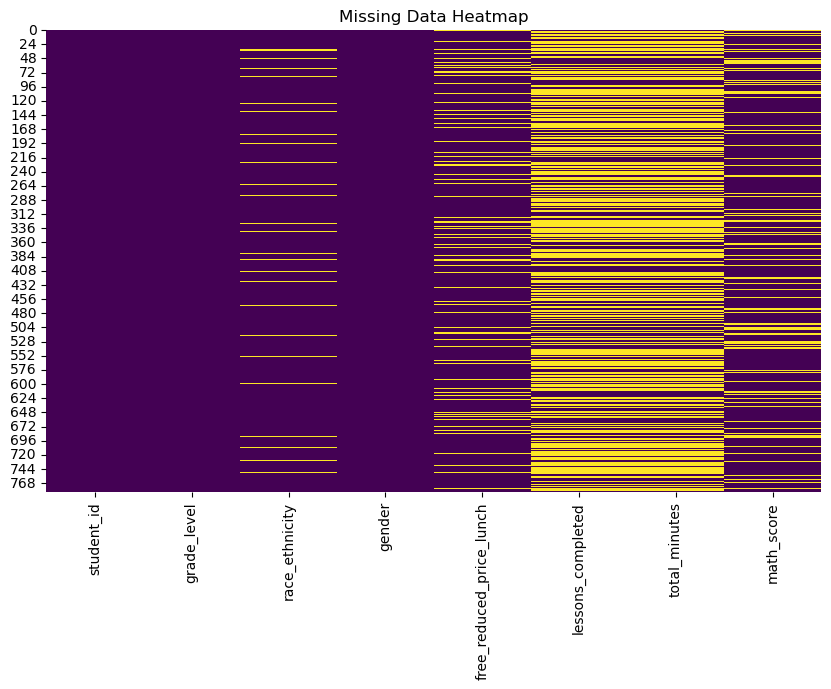

In [61]:
plt.figure(figsize=(10, 6))
sb.heatmap(final_csv.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

In [55]:
# Row count with all non-null values
all_non_null_count = final_csv.dropna(how='any')
all_non_null_count.shape[0]

187

In [57]:
# Row count with non-nulls in math columns
specific_columns = ['lessons_completed', 'total_minutes', 'math_score']
non_null_specific = final_csv[specific_columns].dropna(how='any')
non_null_specific.shape[0]

231

In [59]:
# Row count with null values from both merged files
all_null_specific = final_csv[specific_columns].isnull().all(axis=1)
all_null_specific.sum()

33

## Missing Data Compared to Demographics

In [79]:
# Setup
demographics = ['grade_level', 'race_ethnicity', 'gender', 'free_reduced_price_lunch']
missingness_columns = ['lessons_completed', 'math_score']

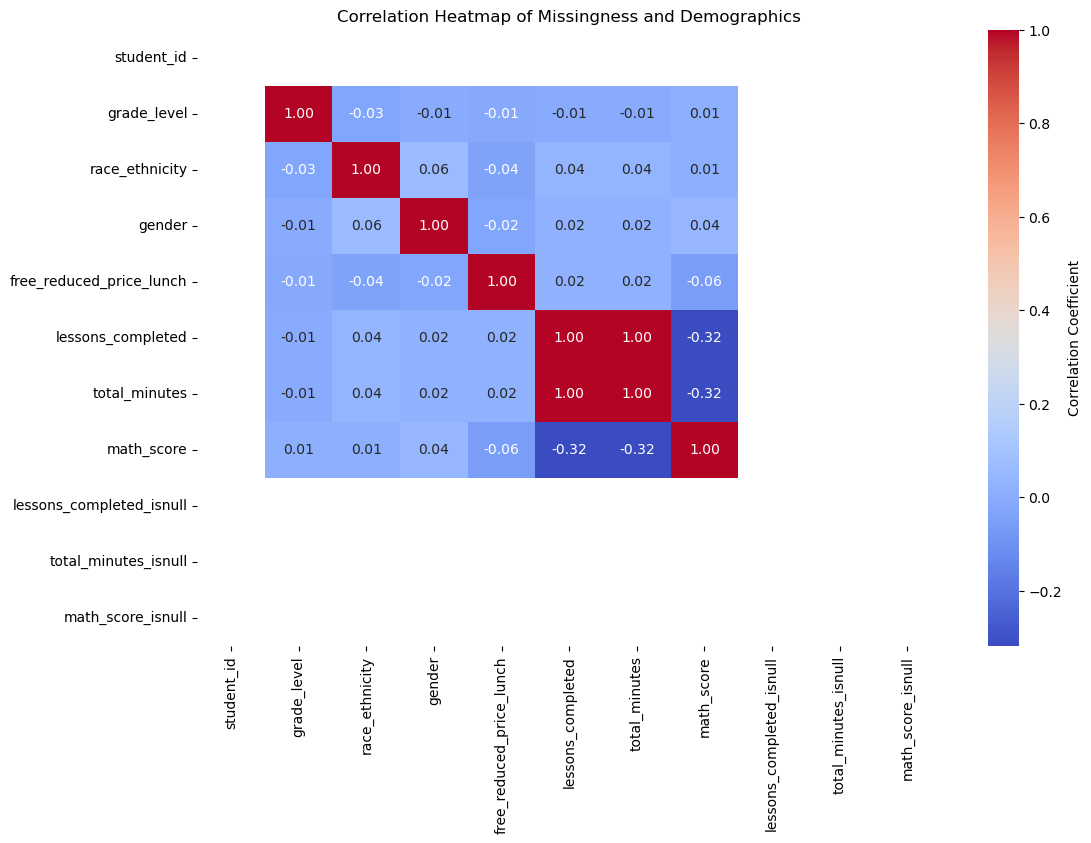

In [77]:
# Generate missingness indicators
missingness_df = final_csv.isnull().astype(int)

# Add demographic indicators
for col in demographics:
    missingness_df[col] = final_csv[col].astype('category').cat.codes

# Calculate correlations
correlation_matrix = missingness_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title("Correlation Heatmap of Missingness and Demographics")
plt.show()


In [65]:
# Check correlation between demographics and nulls.
binary_nulls_df = final_csv.copy()
for col in missingness_columns:
    binary_nulls_df[f'{col}_isnull'] = binary_nulls_df[col].isnull().astype(int)
binary_nulls_df.head()

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,total_minutes,math_score,lessons_completed_isnull,total_minutes_isnull,math_score_isnull
0,1254353,7,White,Male,No,24,21.040558,289,0,0,0
1,1254135,5,White,Male,NaN,1,53.124390,<NA>,0,0,1
2,1254423,8,Black/African American,Male,Reduced Price,<NA>,NaN,614,1,1,0
3,1254598,8,White,Male,Free,<NA>,NaN,578,1,1,0
4,1254562,6,Black/African American,Male,No,<NA>,NaN,395,1,1,0


In [66]:
for col in demographics:
    for missing_col in missingness_columns:
        crosstab = pd.crosstab(binary_nulls_df[col], binary_nulls_df[f'{missing_col}_isnull'])
        print(f"Correlation between {col} and missingness in {missing_col}:")
        print(crosstab)

Correlation between grade_level and missingness in lessons_completed:
lessons_completed_isnull   0    1
grade_level                      
5                         80  106
6                         81  109
7                         89  108
8                         91  119
Correlation between grade_level and missingness in math_score:
math_score_isnull    0   1
grade_level               
5                  152  34
6                  157  33
7                  161  36
8                  170  40
Correlation between race_ethnicity and missingness in lessons_completed:
lessons_completed_isnull                  0    1
race_ethnicity                                  
American Indian/Alaska Native             4    3
Asian                                    13   11
Black/African American                  106  127
Hispanic/Latino                           9   14
Native Havaiian/Other Pacific Islander    6    7
Two or More Races                        19   20
White                               

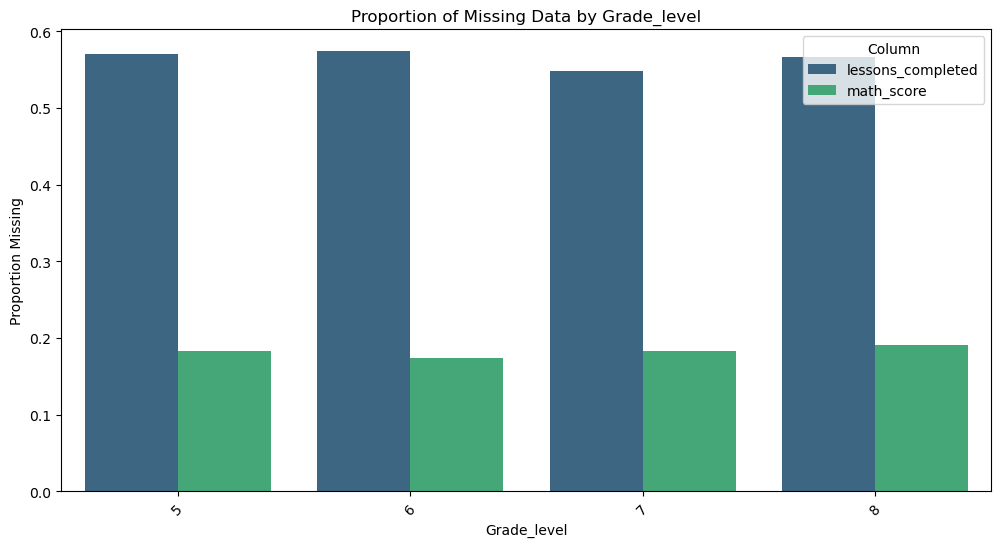

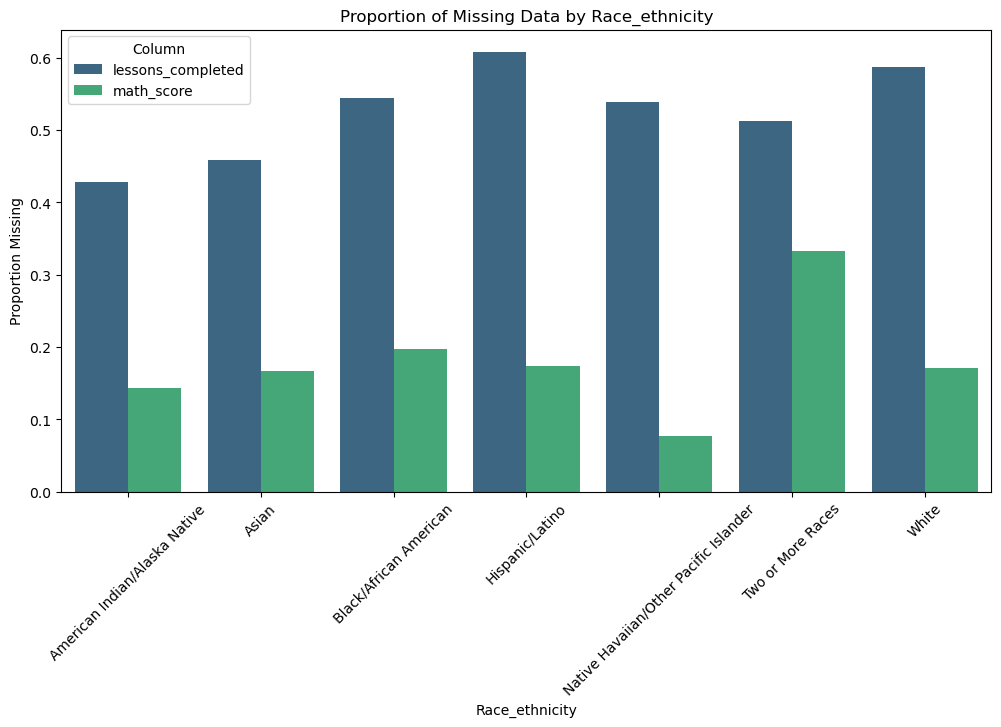

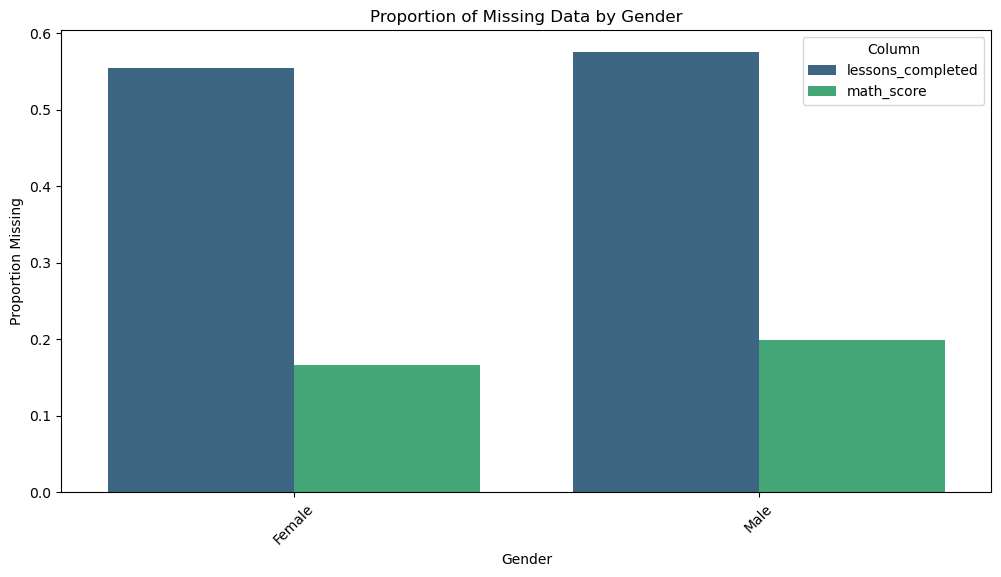

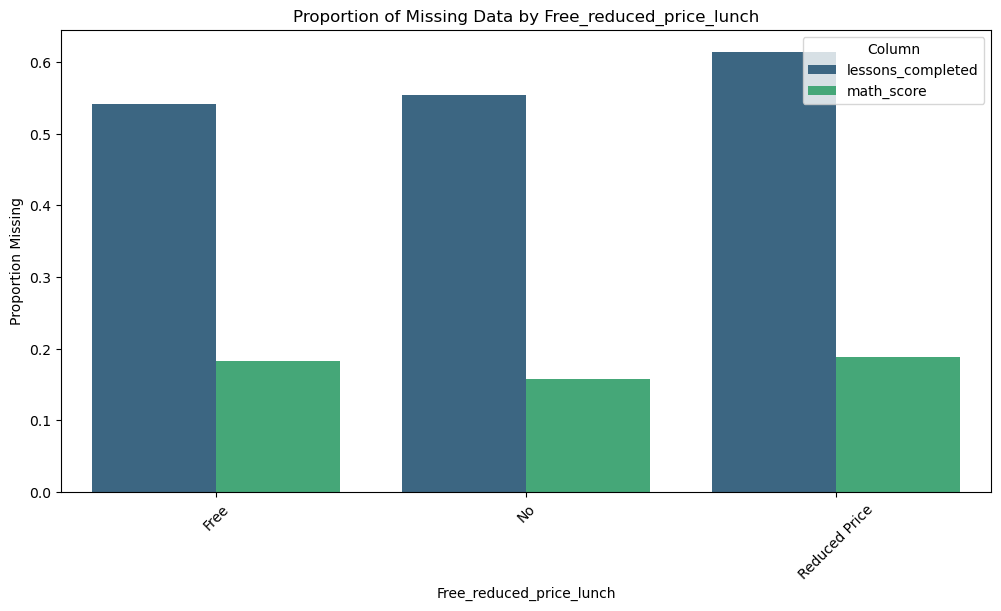

In [82]:
for demo_col in demographics:
    # Calculate proportions for missing values
    proportions = (
        merged_df.groupby(demo_col)[missingness_columns]
        .apply(lambda x: x.isnull().mean())
        .reset_index()
        .melt(id_vars=demo_col, var_name='Column', value_name='Proportion Missing')
    )
    
    # Plot the proportions
    plt.figure(figsize=(12, 6))
    sb.barplot(
        x=demo_col, 
        y='Proportion Missing', 
        hue='Column', 
        data=proportions,
        palette="viridis"
    )
    plt.title(f"Proportion of Missing Data by {demo_col.capitalize()}")
    plt.xlabel(demo_col.capitalize())
    plt.ylabel("Proportion Missing")
    plt.xticks(rotation=45)
    plt.legend(title="Column")
    plt.show()


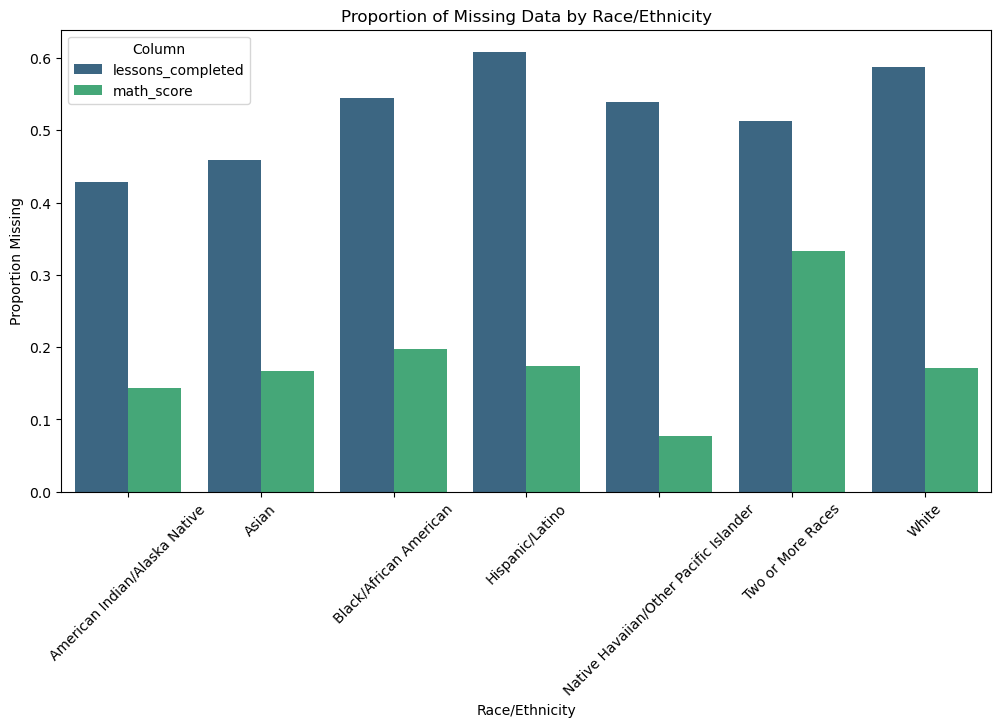

In [80]:
# Calculate proportions for missing values
proportions = (
    final_csv.groupby('race_ethnicity')[missingness_columns]
    .apply(lambda x: x.isnull().mean())
    .reset_index()
    .melt(id_vars='race_ethnicity', var_name='Column', value_name='Proportion Missing')
)

# Plot the proportions
plt.figure(figsize=(12, 6))
sb.barplot(
    x='race_ethnicity', 
    y='Proportion Missing', 
    hue='Column', 
    data=proportions,
    palette="viridis"
)
plt.title("Proportion of Missing Data by Race/Ethnicity")
plt.xlabel("Race/Ethnicity")
plt.ylabel("Proportion Missing")
plt.xticks(rotation=45)
plt.legend(title="Column")
plt.show()

# Math Data Analysis

In [95]:
# Fill NaN in lessons_completed and total_minutes with 0
final_csv['lessons_completed'].fillna(0)
final_csv['total_minutes'].fillna(0)

# Fill NaN in score with -1 to indicate no assessment taken
final_csv['math_score'].fillna(-1)

0      289
1       -1
2      614
3      578
4      395
      ... 
778    290
779    196
780    557
781    433
782    717
Name: math_score, Length: 783, dtype: Int64

In [96]:
final_csv.describe()

,student_id,grade_level,lessons_completed,total_minutes,math_score,lessons_completed_isnull,total_minutes_isnull,math_score_isnull
count,7.830000e+02,783.000000,783.0,783.000000,783.0,783.000000,783.000000,783.000000
mean,1.254464e+06,6.550447,5.601533,33.221716,374.09834,0.564496,0.564496,0.182631
std,2.261769e+02,1.122746,7.792028,52.748358,254.045607,0.496140,0.496140,0.386611
min,1.254073e+06,5.000000,0.0,0.000000,-1.0,0.000000,0.000000,0.000000
25%,1.254268e+06,6.000000,0.0,0.000000,160.5,0.000000,0.000000,0.000000
50%,1.254464e+06,7.000000,0.0,0.000000,386.0,1.000000,1.000000,0.000000
75%,1.254660e+06,8.000000,11.0,53.475554,600.0,1.000000,1.000000,0.000000
max,1.254855e+06,8.000000,24.0,280.517175,798.0,1.000000,1.000000,1.000000


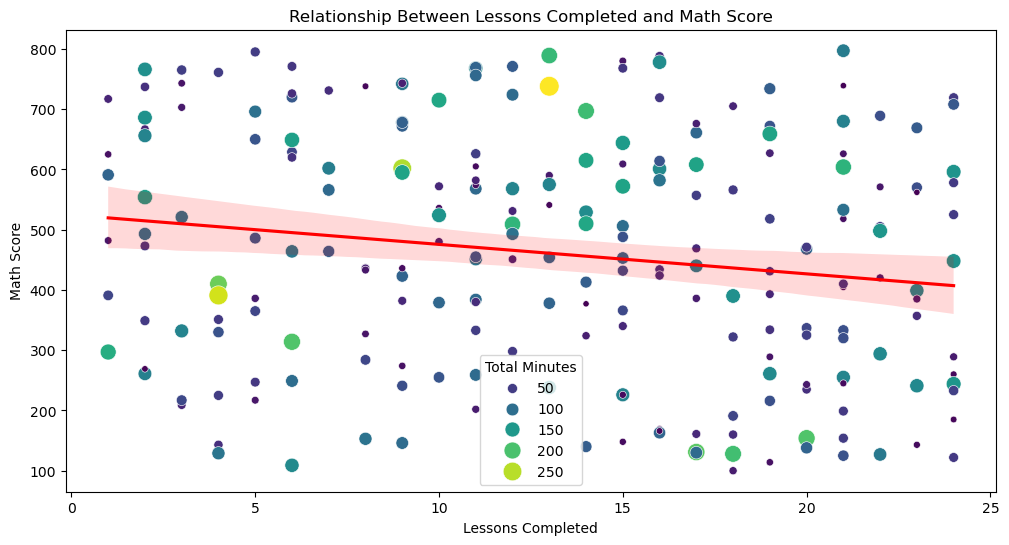

In [86]:
# Filter out rows where math_score = -1 (imputed value for missing scores)
filtered_df = final_csv[final_csv['math_score'] != -1]

# Scatter plot for lessons_completed vs math_score, colored by total_minutes
plt.figure(figsize=(12, 6))
sb.scatterplot(
    x='lessons_completed', 
    y='math_score', 
    hue='total_minutes', 
    size='total_minutes',
    sizes=(20, 200),
    palette='viridis', 
    data=filtered_df
)
sb.regplot(
    x='lessons_completed', 
    y='math_score', 
    scatter=False, 
    data=filtered_df, 
    color='red', 
    line_kws={'label': 'Regression Line'}
)
plt.title("Relationship Between Lessons Completed and Math Score")
plt.xlabel("Lessons Completed")
plt.ylabel("Math Score")
plt.legend(title="Total Minutes")
plt.show()


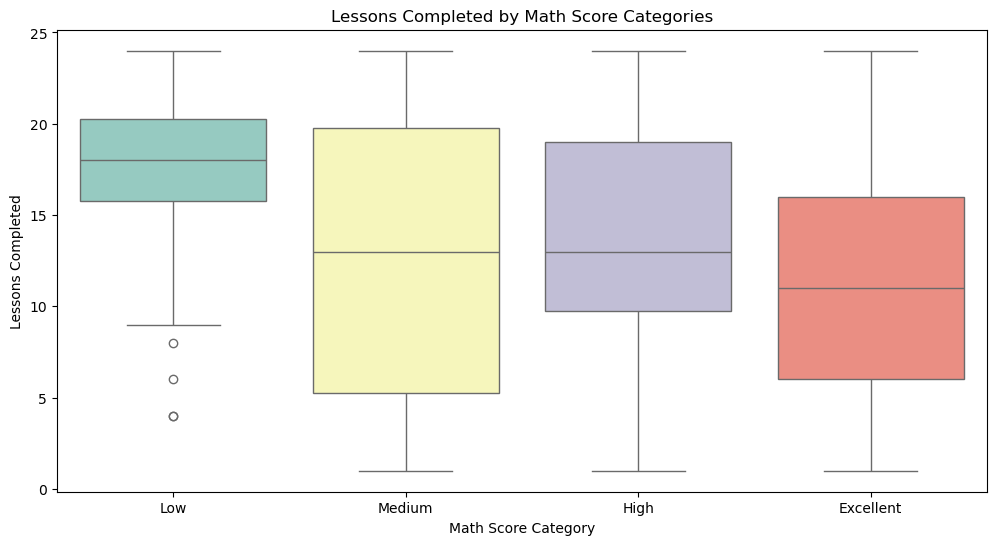

In [93]:
box_df = filtered_df.copy()
# Create categories for math_score
box_df['score_category'] = pd.cut(
    box_df['math_score'], 
    bins=[-1, 200, 400, 600, 800], 
    labels=['Low', 'Medium', 'High', 'Excellent']
)

# Box plot for lessons_completed by math score categories
plt.figure(figsize=(12, 6))
sb.boxplot(
    x='score_category', 
    y='lessons_completed',
    hue='score_category',
    dodge=False,
    data=box_df, 
    palette='Set3'
)
plt.title("Lessons Completed by Math Score Categories")
plt.xlabel("Math Score Category")
plt.ylabel("Lessons Completed")
plt.show()

In [90]:
filtered_df.head()

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,total_minutes,math_score,lessons_completed_isnull,total_minutes_isnull,math_score_isnull,score_category
0,1254353,7,White,Male,No,24,21.040558,289,0,0,0,NaN
2,1254423,8,Black/African American,Male,Reduced Price,<NA>,NaN,614,1,1,0,NaN
3,1254598,8,White,Male,Free,<NA>,NaN,578,1,1,0,NaN
4,1254562,6,Black/African American,Male,No,<NA>,NaN,395,1,1,0,NaN
5,1254213,8,White,Male,No,21,11.374870,518,0,0,0,NaN


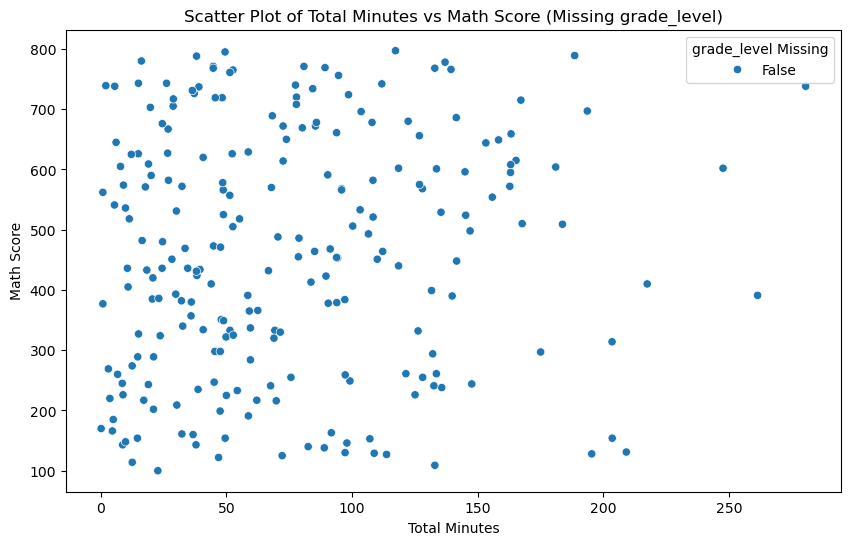

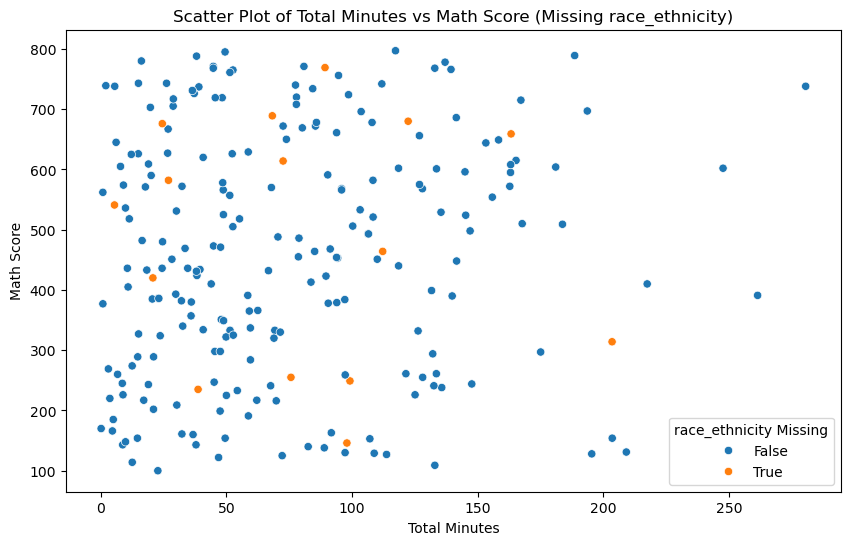

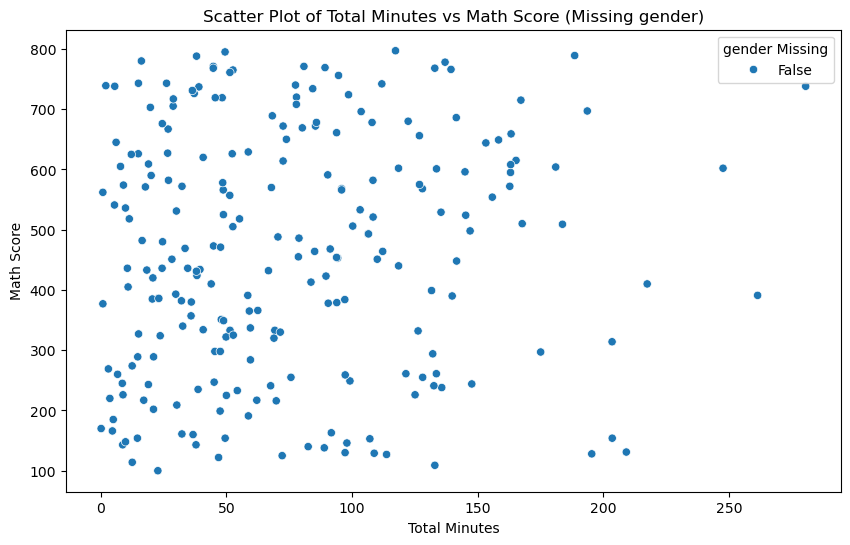

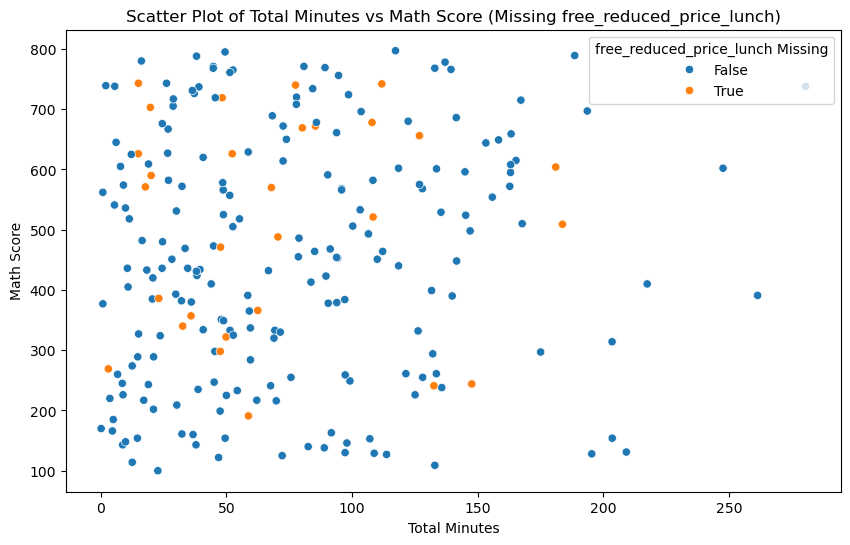

In [72]:
for col in ['grade_level', 'race_ethnicity', 'gender', 'free_reduced_price_lunch']:
    plt.figure(figsize=(10, 6))
    sb.scatterplot(
        x='total_minutes', 
        y='math_score', 
        hue=final_csv[col].isnull(), 
        data=final_csv
    )
    plt.title(f"Scatter Plot of Total Minutes vs Math Score (Missing {col})")
    plt.xlabel("Total Minutes")
    plt.ylabel("Math Score")
    plt.legend(title=f"{col} Missing")
    plt.show()


# Benchmark Data

## Handle Usage Data

In [32]:
# Put Benchmark columns into a list
benchmark_columns = ['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level']

# Check Usage Benchmarks
for col in benchmark_columns:
    print(f"Unique values in {col}: {usage_data[col].unique()}")

Unique values in benchmark_1_level: ['level 2' 'level 3' 'level 1' 'level4']
Unique values in benchmark_2_level: ['level 1' 'level 2' 'level 3' 'level4']
Unique values in benchmark_3_level: ['level 3' 'level4' 'level 1' 'level 2']
Unique values in benchmark_4_level: ['level 2' 'level 1' 'level4' 'level 3']


<div class="alert alert-block alert-danger">
<b>Messy Data in Benchmark Columns:</b> All level values have a space between text and number except for "level4" in each column.
</div>

In [33]:
# Replace "level4" with "level 4" in the specified columns
for column in benchmark_columns:
    usage_data[column] = usage_data[column].replace('level4', 'level 4')

usage_data.head(5)

,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
0,1254110,13,level 2,level 1,level 3,level 2,47.808670
1,1254113,14,level 2,level 1,level 4,level 1,156.792335
2,1254288,16,level 3,level 1,level 3,level 1,38.135959
3,1254095,15,level 3,level 1,level 1,level 1,18.257427
4,1254250,1,level 2,level 1,level 2,level 2,16.479016


In [17]:
# Benchmark level distribution
melted = usage_data.melt(id_vars=['student_id'], 
                       value_vars=['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level'], 
                       var_name='benchmark', 
                       value_name='level')
melted.head(10)

,student_id,benchmark,level
0,1254110,benchmark_1_level,level 2
1,1254113,benchmark_1_level,level 2
2,1254288,benchmark_1_level,level 3
3,1254095,benchmark_1_level,level 3
4,1254250,benchmark_1_level,level 2
5,1254177,benchmark_1_level,level 1
6,1254277,benchmark_1_level,level 3
7,1254078,benchmark_1_level,level 2
8,1254165,benchmark_1_level,level 2
9,1254381,benchmark_1_level,level 3


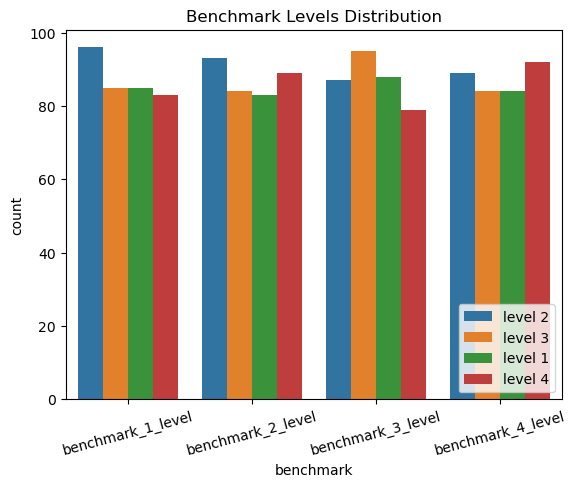

In [18]:
sb.countplot(data=melted, x='benchmark', hue='level')
plt.title("Benchmark Levels Distribution")
plt.xticks(rotation=15)
plt.legend(loc = 4) 
plt.show()

In [48]:
for col in ['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level']:
    print(usage_data[col].value_counts())


benchmark_1_level
level 2    96
level 3    85
level 1    85
level4     83
Name: count, dtype: int64
benchmark_2_level
level 2    93
level4     89
level 3    84
level 1    83
Name: count, dtype: int64
benchmark_3_level
level 3    95
level 1    88
level 2    87
level4     79
Name: count, dtype: int64
benchmark_4_level
level4     92
level 2    89
level 1    84
level 3    84
Name: count, dtype: int64


# Scratch Pad

In [51]:
for col in ['lessons_completed']:
    print(f"Correlation with total_minutes for {col}: {usage_data[col].corr(usage_data['total_minutes'])}")


Correlation with total_minutes for lessons_completed: -0.04444975594260643


In [52]:
# Correlations
for col in ['lessons_completed', 'total_minutes']:
    print(f"Correlation with Score for {col}: {merged_df[col].corr(merged_df['score'])}")


Correlation with Score for lessons_completed: -0.16664187473992423
Correlation with Score for total_minutes: 0.1072420936688609


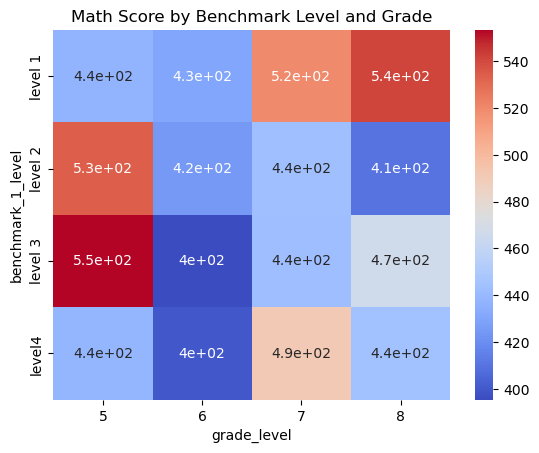

In [54]:
heatmap_data = merged_df.groupby(['benchmark_1_level', 'grade_level'])['score'].mean().unstack()
sb.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title("Math Score by Benchmark Level and Grade")
plt.show()
